# Chapter 3.5

## Importing Libraries

In [1]:
from __future__ import absolute_import, division, print_function
from __future__ import unicode_literals

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import tqdm
from hfunc import models
from hfunc import metrics
import time

## Self-created functions

In [3]:
def node_pruning(model, tester_model, x, y, layer_sizes, tol, ignore_cutoff, method='exhaustive'):

    loss, acc = model.evaluate(x, y, verbose=0, batch_size=256)
    original = model.get_weights()
    weight_len = len(original) - 3
    bas = [acc]
    bls = [loss]
    best_weights = model.get_weights()
    best_acc = 0
    best_loss = 1e20
    ol = loss
    oa = acc
    amounts = []
    places = []

    for layer, size in enumerate(layer_sizes):
        end_not_reached = True
        num_removed = 0
        nodes_removed = []
        if method == 'exhaustive':
            current_pos = 0
            best_change = tol
            best_pos = -1
            improved = False
            while end_not_reached or improved:
                if not(end_not_reached):
                    end_not_reached = True
                    improved = False
                    current_pos = 0
                    size -= 1
                    nodes_removed += [best_pos]
                    best_weights[weight_len - (2*layer+1)][...,best_pos] = 0
                    best_weights[weight_len - 2*layer][best_pos] = 0
                    best_pos = -1
                    ol = best_loss
                    oa = best_acc
                    bas += [best_acc]
                    bls += [best_loss]
                    best_change = tol
                    num_removed += 1
                if current_pos in nodes_removed:
                    current_pos += 1
                    if current_pos - num_removed >= size:
                        end_not_reached = False
                    continue
                w = copy.deepcopy(best_weights)
                w[weight_len - (2*layer+1)][...,current_pos] = 0
                w[weight_len - 2*layer][current_pos] = 0
                tester_model.set_weights(w)
                nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
                if ol - nl >= best_change:
                    best_change = ol - nl
                    best_pos = current_pos
                    improved = True
                    best_acc = na
                    best_loss = nl
                current_pos += 1
                if current_pos - num_removed >= size:
                    end_not_reached = False
        elif method == 'greedy':
            nodes_to_estimate = list(np.arange(size))
            current_pos = nodes_to_estimate[0]
            idx = 0
            while end_not_reached:
                w = copy.deepcopy(best_weights)
                w[weight_len - (2*layer+1)][...,current_pos] = 0
                w[weight_len - 2*layer][current_pos] = 0
                tester_model.set_weights(w)
                nl, na = tester_model.evaluate(x, y, verbose=0, batch_size=256)
                if ol - nl >= tol:
                    oa = na
                    ol = nl
                    size -= 1
                    nodes_removed += [current_pos]
                    nodes_to_estimate.remove(current_pos)
                    best_weights[weight_len - (2*layer+1)][..., current_pos] = 0
                    best_weights[weight_len - 2*layer][current_pos] = 0
                    bas += [oa]
                    bls += [ol]
                    num_removed += 1
                    idx = 0
                elif ol - nl <= ignore_cutoff:
                    size -= 1
                    nodes_to_estimate.remove(current_pos)
                else:
                    idx += 1
                if idx >= size:
                    end_not_reached = False
                else:
                    current_pos = nodes_to_estimate[idx]
        amounts.append(num_removed)
        places.append(nodes_removed)

    return best_weights, bas, bls, amounts, places

## Multi-layer Perceptron

### MNIST

In [4]:
np.random.seed(2020)

In [5]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [6]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [8]:
trials = 10
tol = -1e-5
layer_sizes = [32, 64, 128]
num_rem_ex = []
num_rem_greed = []
num_rem_greed2 = []
delta_accs_ex = []
delta_losses_ex = []
delta_accs_greed = []
delta_losses_greed = []
delta_accs_greed2 = []
delta_losses_greed2 = []
diff_accs = []
diff_losses = []
diff_rem = []
diff_rem2 = []
diff_accs2 = []
diff_losses2 = []
time_ex = []
time_greed = []
time_greed2 = []

for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    
    ig_cut = None
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut)
    end = time.time()
    num_rem_ex += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_ex += [na - a]
    delta_losses_ex += [nl - l]
    time_ex += [end - start]
    
    ig_cut = -1e-2
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
    end = time.time()
    num_rem_greed += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_greed += [na - a]
    delta_losses_greed += [nl - l]
    time_greed += [end - start]
    
    ig_cut = -1e-3
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
    end = time.time()
    num_rem_greed2 += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_greed2 += [na - a]
    delta_losses_greed2 += [nl - l]
    time_greed2 += [end - start]
    
    diff_accs += [delta_accs_ex[trial] - delta_accs_greed[trial]]
    diff_accs2 += [delta_accs_ex[trial] - delta_accs_greed2[trial]]
    diff_losses += [delta_losses_ex[trial] - delta_losses_greed[trial]]
    diff_losses2 += [delta_losses_ex[trial] - delta_losses_greed2[trial]]
    temp_rem = []
    temp_rem2 = []
    for i in range(len(layer_sizes)):   
        temp_rem += [num_rem_greed[trial][i] - num_rem_ex[trial][i]]
        temp_rem2 += [num_rem_greed2[trial][i] - num_rem_ex[trial][i]]
        
    diff_rem += [temp_rem]
    diff_rem2 += [temp_rem2]

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [43:49<00:00, 262.97s/it]


In [9]:
DR = pd.DataFrame(diff_rem, columns=["Layer 3", "Layer 2", "Layer 1"])
DR.to_csv('../../../results/num_removed_MLP_greed_ex_mnist.csv')
DR.describe()

,Layer 3,Layer 2,Layer 1
count,10.000000,10.00000,10.000000
mean,0.200000,2.80000,2.300000
std,0.421637,1.75119,4.571652
min,0.000000,1.00000,-4.000000
25%,0.000000,1.25000,-0.750000
50%,0.000000,2.50000,2.000000
75%,0.000000,3.75000,6.000000
max,1.000000,6.00000,8.000000


In [10]:
DR2 = pd.DataFrame(diff_rem2, columns=["Layer 3", "Layer 2", "Layer 1"])
DR2.to_csv('../../../results/num_removed_MLP_greed_ex_2_mnist.csv')
DR2.describe()

,Layer 3,Layer 2,Layer 1
count,10.000000,10.000000,10.00000
mean,0.300000,2.400000,1.90000
std,0.483046,1.897367,4.45845
min,0.000000,-1.000000,-4.00000
25%,0.000000,1.250000,-2.00000
50%,0.000000,2.500000,2.00000
75%,0.750000,3.000000,5.50000
max,1.000000,6.000000,8.00000


In [11]:
A = pd.DataFrame([delta_accs_ex, delta_accs_greed, delta_accs_greed2])
A = A.T
A.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
A.to_csv('../../../results/change_accuracy_MLP_greed_ex_mnist.csv')
A.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,10.000000,10.000000,10.000000
mean,0.001490,0.000440,0.000610
std,0.001457,0.001272,0.001542
min,-0.000800,-0.002200,-0.002200
25%,0.000925,0.000375,-0.000375
50%,0.001500,0.001000,0.000450
75%,0.002375,0.001100,0.001475
max,0.004100,0.001600,0.002800


In [12]:
L = pd.DataFrame([delta_losses_ex, delta_losses_greed, delta_losses_greed2])
L = L.T
L.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
L.to_csv('../../../results/change_loss_MLP_greed_ex_mnist.csv')
L.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,10.000000,10.000000,10.000000
mean,-0.009914,-0.006886,-0.005791
std,0.005107,0.003682,0.004266
min,-0.017434,-0.011719,-0.011755
25%,-0.013531,-0.009434,-0.009451
50%,-0.010183,-0.007802,-0.005568
75%,-0.008554,-0.004168,-0.003246
max,-0.000323,-0.001272,0.001590


In [13]:
DA = pd.Series(diff_accs)
DA.to_csv('../../../results/diff_accuracy_MLP_greed_ex_mnist.csv')
DA.describe()

count    10.000000
mean      0.001050
std       0.001032
min      -0.000700
25%       0.000475
50%       0.000950
75%       0.001375
max       0.003200
dtype: float64

In [14]:
DA2 = pd.Series(diff_accs2)
DA2.to_csv('../../../results/diff_accuracy_MLP_greed_ex_2_mnist.csv')
DA2.describe()

count    10.000000
mean      0.000880
std       0.001129
min      -0.001200
25%       0.000175
50%       0.000900
75%       0.001375
max       0.002900
dtype: float64

In [15]:
DL = pd.Series(diff_losses)
DL.to_csv('../../../results/diff_loss_MLP_greed_ex_mnist.csv')
DL.describe()

count    10.000000
mean     -0.003028
std       0.003982
min      -0.010799
25%      -0.004039
50%      -0.002284
75%      -0.000107
max       0.001488
dtype: float64

In [16]:
DL2 = pd.Series(diff_losses2)
DL2.to_csv('../../../results/diff_loss_MLP_greed_ex_2_mnist.csv')
DL2.describe()

count    10.000000
mean     -0.004123
std       0.003553
min      -0.010799
25%      -0.005386
50%      -0.004615
75%      -0.002026
max       0.000914
dtype: float64

In [17]:
Time = pd.DataFrame([time_ex, time_greed, time_greed2])
Time = Time.T
Time.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
Time.to_csv('../../../results/time_MLP_greed_ex_mnist.csv')
Time.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,10.000000,10.000000,10.000000
mean,150.745942,73.599482,30.094963
std,20.714156,16.158160,3.074225
min,118.610501,56.285822,23.575500
25%,139.513302,58.842251,28.953284
50%,143.729001,68.980250,29.914250
75%,166.014252,88.641125,31.807748
max,189.810888,95.320497,34.453000


In [18]:
diff_rem = [sum(rem) for rem in diff_rem]

In [19]:
diff_rem2 = [sum(rem) for rem in diff_rem2]

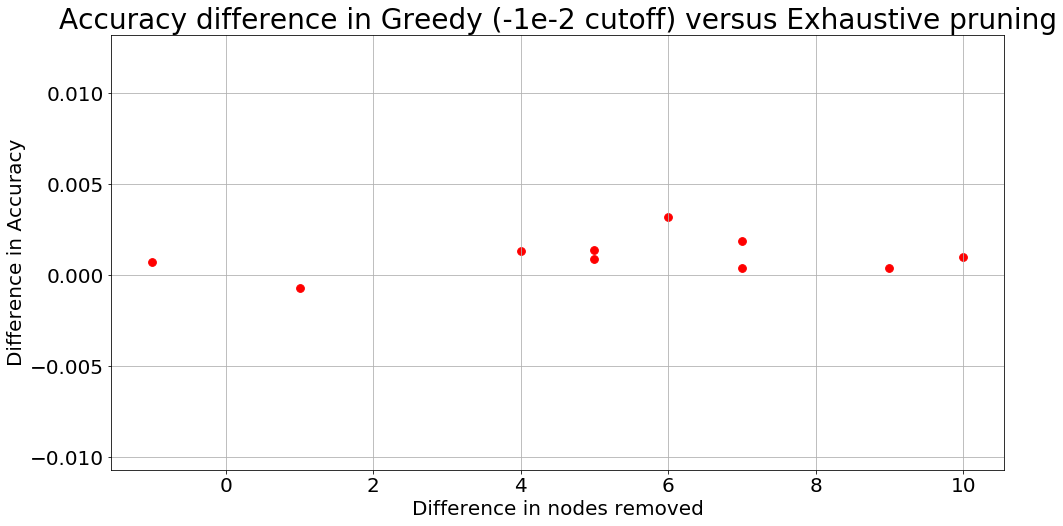

In [20]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=diff_rem, y=diff_accs, marker='o', color='red', s=60)
plt.title("Accuracy difference in Greedy (-1e-2 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_accuracy_vs_nodes_removed_MLP_greed_ex_mnist.png")

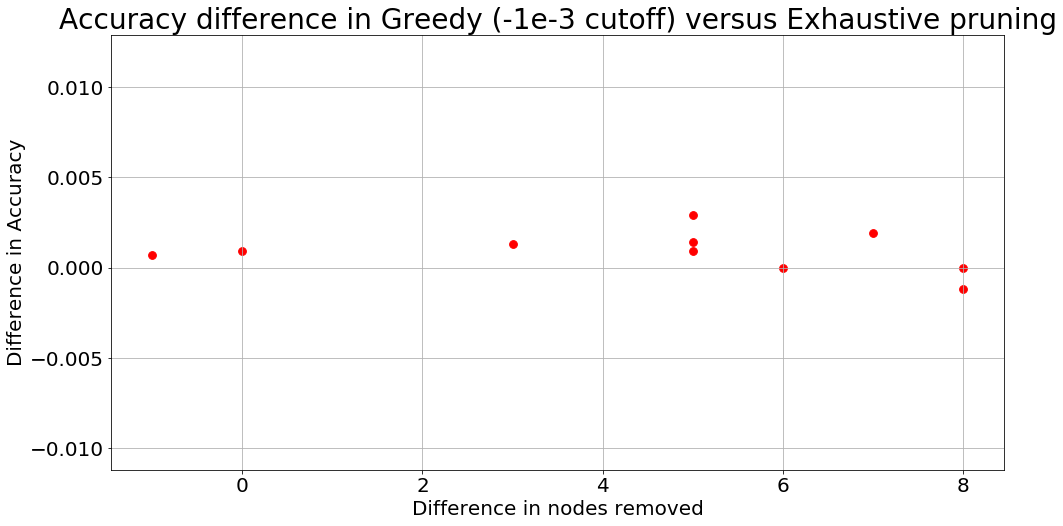

In [21]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=diff_rem2, y=diff_accs2, marker='o', color='red', s=60)
plt.title("Accuracy difference in Greedy (-1e-3 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_accuracy_vs_nodes_removed_MLP_greed_ex_2_mnist.png")

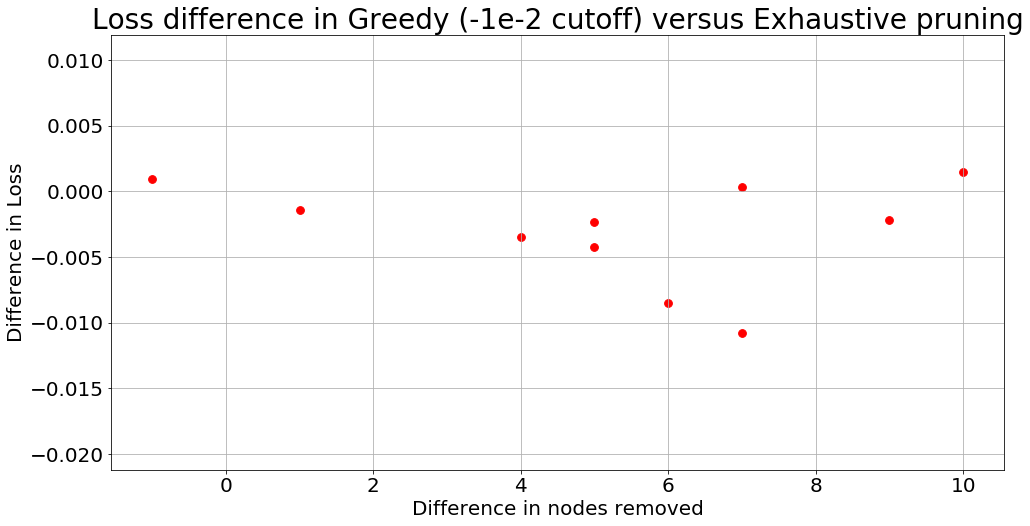

In [22]:
plt.scatter(x=diff_rem, y=diff_losses, marker='o', color='red', s=60)
plt.title("Loss difference in Greedy (-1e-2 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_loss_vs_nodes_removed_MLP_greed_ex_mnist.png")

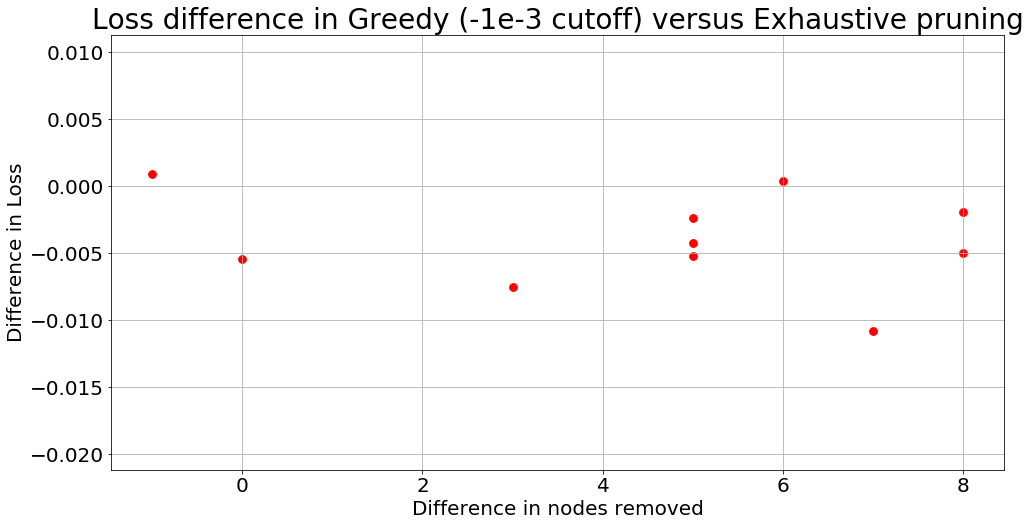

In [23]:
plt.scatter(x=diff_rem2, y=diff_losses2, marker='o', color='red', s=60)
plt.title("Loss difference in Greedy (-1e-3 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_loss_vs_nodes_removed_MLP_greed_ex_2_mnist.png")

In [24]:
tol = -1e-5
ig_cut = -1e-3
layer_sizes = [32, 64, 128]
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [25]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.09550989419221878, New loss: 0.08543939143419266
Original accuracy: 0.9731000065803528, New accuracy: 0.9746000170707703
Number of nodes removed: [6, 15, 11]


In [26]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

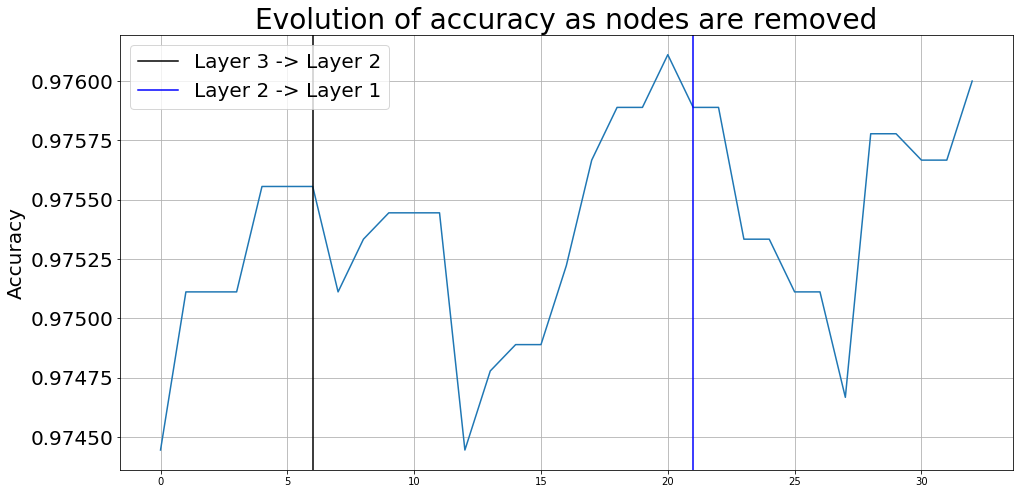

In [27]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_MLP_greed_pru_mnist.png")

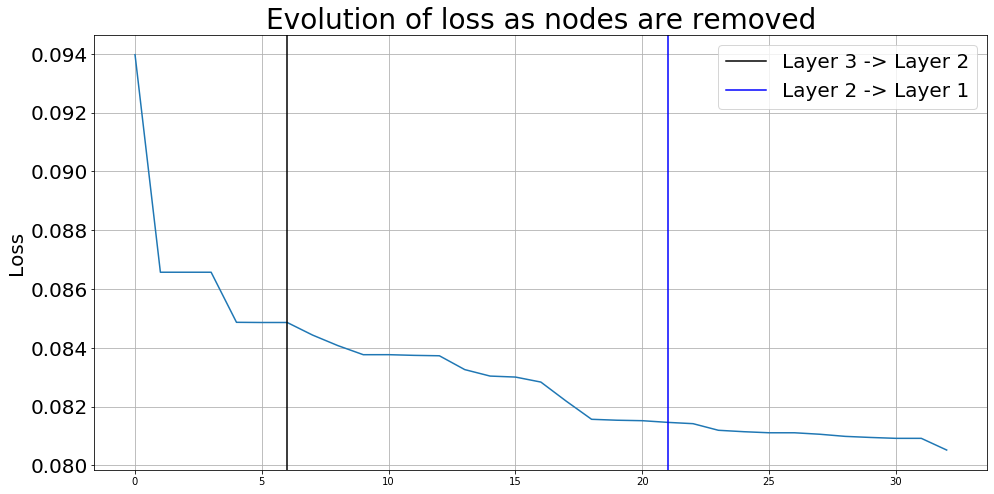

In [28]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_MLP_greed_pru_mnist.png")

### Fashion MNIST

#### Set seed

In [29]:
np.random.seed(2020)

In [30]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [31]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [33]:
trials = 10
tol = -1e-5
layer_sizes = [32, 64, 128]
num_rem_ex = []
num_rem_greed = []
num_rem_greed2 = []
delta_accs_ex = []
delta_losses_ex = []
delta_accs_greed = []
delta_losses_greed = []
delta_accs_greed2 = []
delta_losses_greed2 = []
diff_accs = []
diff_losses = []
diff_rem = []
diff_rem2 = []
diff_accs2 = []
diff_losses2 = []
time_ex = []
time_greed = []
time_greed2 = []

for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    
    ig_cut = None
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut)
    end = time.time()
    num_rem_ex += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_ex += [na - a]
    delta_losses_ex += [nl - l]
    time_ex += [end - start]
    
    ig_cut = -1e-2
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
    end = time.time()
    num_rem_greed += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_greed += [na - a]
    delta_losses_greed += [nl - l]
    time_greed += [end - start]
    
    ig_cut = -1e-3
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
    end = time.time()
    num_rem_greed2 += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_greed2 += [na - a]
    delta_losses_greed2 += [nl - l]
    time_greed2 += [end - start]
    
    diff_accs += [delta_accs_ex[trial] - delta_accs_greed[trial]]
    diff_accs2 += [delta_accs_ex[trial] - delta_accs_greed2[trial]]
    diff_losses += [delta_losses_ex[trial] - delta_losses_greed[trial]]
    diff_losses2 += [delta_losses_ex[trial] - delta_losses_greed2[trial]]
    temp_rem = []
    temp_rem2 = []
    for i in range(len(layer_sizes)):   
        temp_rem += [num_rem_greed[trial][i] - num_rem_ex[trial][i]]
        temp_rem2 += [num_rem_greed2[trial][i] - num_rem_ex[trial][i]]
        
    diff_rem += [temp_rem]
    diff_rem2 += [temp_rem2]

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:08:19<00:00, 409.90s/it]


In [34]:
DR = pd.DataFrame(diff_rem, columns=["Layer 3", "Layer 2", "Layer 1"])
DR.to_csv('../../../results/num_removed_MLP_greed_ex_fmnist.csv')
DR.describe()

,Layer 3,Layer 2,Layer 1
count,10.000000,10.000000,10.000000
mean,0.400000,0.400000,1.600000
std,1.074968,1.429841,3.025815
min,-1.000000,-2.000000,-5.000000
25%,0.000000,0.000000,0.250000
50%,0.000000,0.000000,2.000000
75%,0.750000,1.000000,4.000000
max,3.000000,3.000000,5.000000


In [35]:
DR2 = pd.DataFrame(diff_rem2, columns=["Layer 3", "Layer 2", "Layer 1"])
DR2.to_csv('../../../results/num_removed_MLP_greed_ex_2_fmnist.csv')
DR2.describe()

,Layer 3,Layer 2,Layer 1
count,10.000000,10.000000,10.000000
mean,0.400000,0.400000,1.500000
std,1.074968,1.429841,3.135815
min,-1.000000,-2.000000,-5.000000
25%,0.000000,0.000000,0.250000
50%,0.000000,0.000000,2.000000
75%,0.750000,1.000000,4.000000
max,3.000000,3.000000,5.000000


In [36]:
A = pd.DataFrame([delta_accs_ex, delta_accs_greed, delta_accs_greed2])
A = A.T
A.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
A.to_csv('../../../results/change_accuracy_MLP_greed_ex_fmnist.csv')
A.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,10.000000,10.000000,10.000000
mean,0.004110,0.004120,0.004130
std,0.003787,0.002466,0.002461
min,0.000000,0.000900,0.000900
25%,0.001075,0.001775,0.001800
50%,0.002950,0.004300,0.004300
75%,0.007525,0.006200,0.006200
max,0.010200,0.007300,0.007300


In [37]:
L = pd.DataFrame([delta_losses_ex, delta_losses_greed, delta_losses_greed2])
L = L.T
L.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
L.to_csv('../../../results/change_loss_MLP_greed_ex_fmnist.csv')
L.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,10.000000,10.000000,10.000000
mean,-0.012384,-0.010178,-0.010059
std,0.007661,0.005862,0.005892
min,-0.021754,-0.018943,-0.018943
25%,-0.019179,-0.014952,-0.014952
50%,-0.013035,-0.008902,-0.008437
75%,-0.006243,-0.005802,-0.006001
max,-0.000652,-0.001525,-0.001525


In [38]:
DA = pd.Series(diff_accs)
DA.to_csv('../../../results/diff_accuracy_MLP_greed_ex_fmnist.csv')
DA.describe()

count    10.000000
mean     -0.000010
std       0.002204
min      -0.003800
25%      -0.001000
50%      -0.000450
75%       0.001550
max       0.003800
dtype: float64

In [39]:
DA2 = pd.Series(diff_accs2)
DA2.to_csv('../../../results/diff_accuracy_MLP_greed_ex_2_fmnist.csv')
DA2.describe()

count    10.000000
mean     -0.000020
std       0.002207
min      -0.003800
25%      -0.001025
50%      -0.000450
75%       0.001550
max       0.003800
dtype: float64

In [40]:
DL = pd.Series(diff_losses)
DL.to_csv('../../../results/diff_loss_MLP_greed_ex_fmnist.csv')
DL.describe()

count    10.000000
mean     -0.002206
std       0.004007
min      -0.011370
25%      -0.003282
50%      -0.000595
75%       0.000271
max       0.000972
dtype: float64

In [41]:
DL2 = pd.Series(diff_losses2)
DL2.to_csv('../../../results/diff_loss_MLP_greed_ex_2_fmnist.csv')
DL2.describe()

count    10.000000
mean     -0.002324
std       0.004476
min      -0.013082
25%      -0.003282
50%      -0.000332
75%       0.000271
max       0.000972
dtype: float64

In [42]:
Time = pd.DataFrame([time_ex, time_greed, time_greed2])
Time = Time.T
Time.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
Time.to_csv('../../../results/time_MLP_greed_ex_fmnist.csv')
Time.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,10.000000,10.000000,10.000000
mean,256.680690,103.866906,40.890400
std,38.375942,11.496810,5.751160
min,186.685002,85.838998,33.239499
25%,239.470215,94.700749,35.961626
50%,255.321833,104.550501,41.232000
75%,277.029001,114.044000,44.404625
max,321.647500,119.494067,49.473000


In [43]:
diff_rem = [sum(rem) for rem in diff_rem]

In [44]:
diff_rem2 = [sum(rem) for rem in diff_rem2]

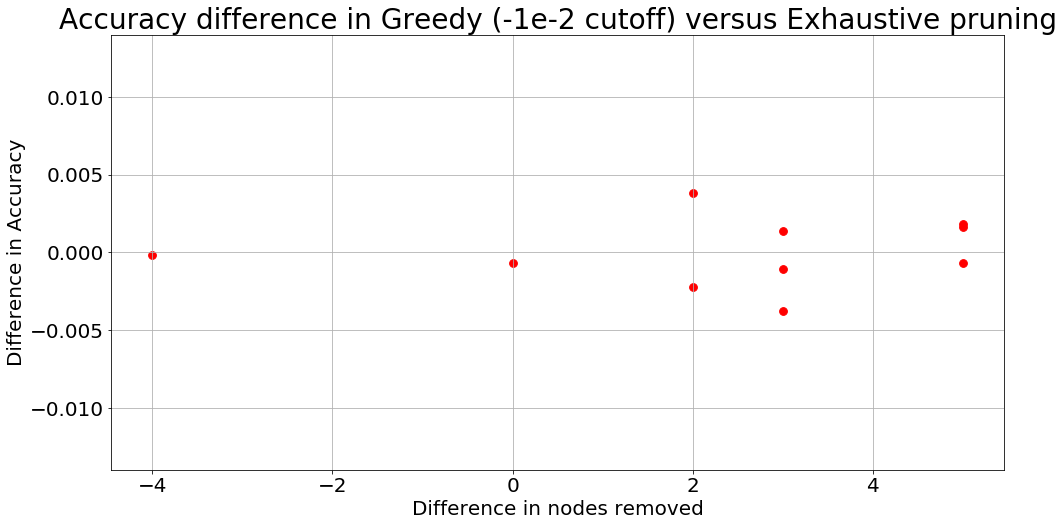

In [45]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=diff_rem, y=diff_accs, marker='o', color='red', s=60)
plt.title("Accuracy difference in Greedy (-1e-2 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_accuracy_vs_nodes_removed_MLP_greed_ex_fmnist.png")

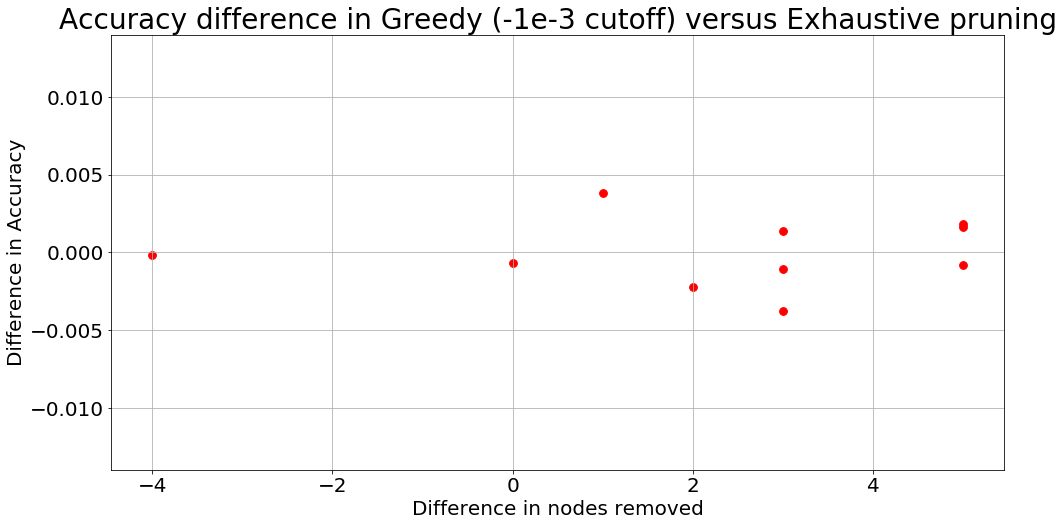

In [46]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=diff_rem2, y=diff_accs2, marker='o', color='red', s=60)
plt.title("Accuracy difference in Greedy (-1e-3 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_accuracy_vs_nodes_removed_MLP_greed_ex_2_fmnist.png")

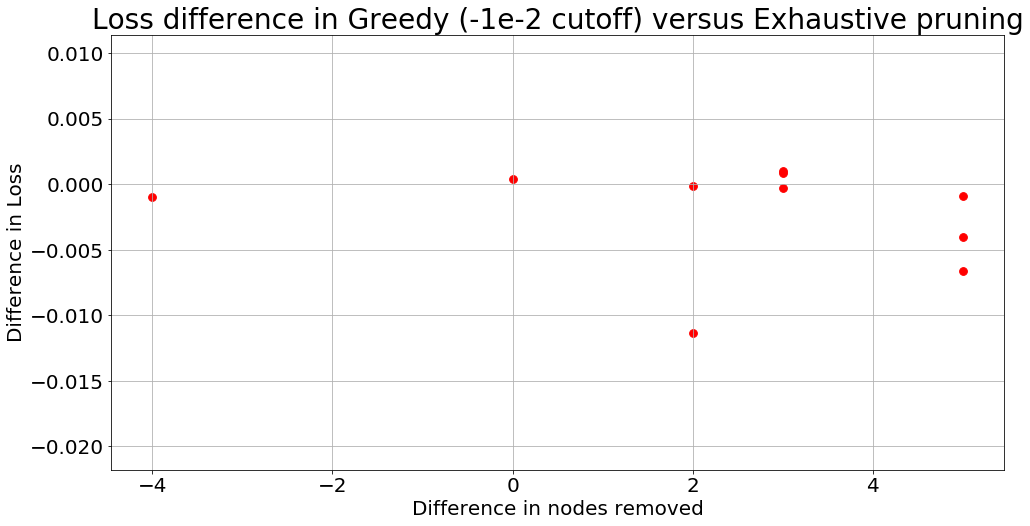

In [47]:
plt.scatter(x=diff_rem, y=diff_losses, marker='o', color='red', s=60)
plt.title("Loss difference in Greedy (-1e-2 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_loss_vs_nodes_removed_MLP_greed_ex_fmnist.png")

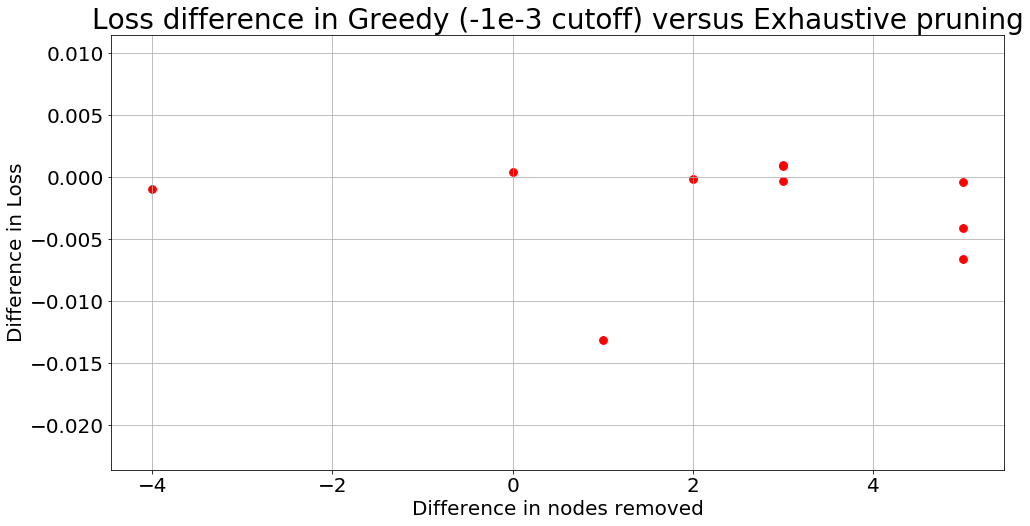

In [48]:
plt.scatter(x=diff_rem2, y=diff_losses2, marker='o', color='red', s=60)
plt.title("Loss difference in Greedy (-1e-3 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_loss_vs_nodes_removed_MLP_greed_ex_2_fmnist.png")

In [49]:
tol = -1e-5
ig_cut = -1e-3
layer_sizes = [32, 64, 128]
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [50]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.3680803179740906, New loss: 0.34562379121780396
Original accuracy: 0.866100013256073, New accuracy: 0.8770999908447266
Number of nodes removed: [6, 16, 24]


In [51]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

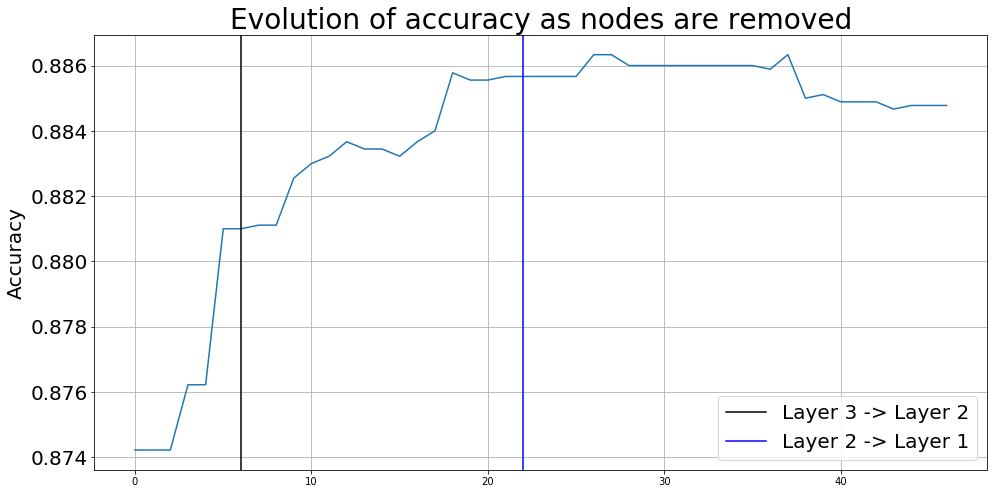

In [52]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_MLP_greed_pru_fmnist.png")

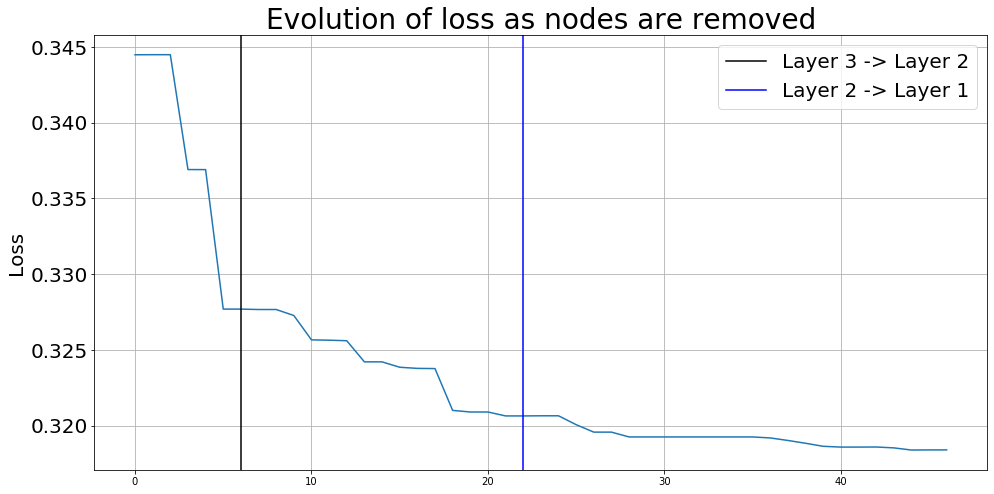

In [53]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_MLP_greed_pru_fmnist.png")

## Convolutional Neural Network

### MNIST

In [54]:
np.random.seed(2020)

In [55]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

In [56]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [57]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [58]:
trials = 5
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
num_rem_ex = []
num_rem_greed = []
num_rem_greed2 = []
delta_accs_ex = []
delta_losses_ex = []
delta_accs_greed = []
delta_losses_greed = []
delta_accs_greed2 = []
delta_losses_greed2 = []
diff_accs = []
diff_losses = []
diff_rem = []
diff_rem2 = []
diff_accs2 = []
diff_losses2 = []
time_ex = []
time_greed = []
time_greed2 = []

for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    
    ig_cut = None
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut)
    end = time.time()
    num_rem_ex += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_ex += [na - a]
    delta_losses_ex += [nl - l]
    time_ex += [end - start]
    
    ig_cut = -1e-2
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
    end = time.time()
    num_rem_greed += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_greed += [na - a]
    delta_losses_greed += [nl - l]
    time_greed += [end - start]
    
    ig_cut = -1e-3
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
    end = time.time()
    num_rem_greed2 += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_greed2 += [na - a]
    delta_losses_greed2 += [nl - l]
    time_greed2 += [end - start]
    
    diff_accs += [delta_accs_ex[trial] - delta_accs_greed[trial]]
    diff_accs2 += [delta_accs_ex[trial] - delta_accs_greed2[trial]]
    diff_losses += [delta_losses_ex[trial] - delta_losses_greed[trial]]
    diff_losses2 += [delta_losses_ex[trial] - delta_losses_greed2[trial]]
    temp_rem = []
    temp_rem2 = []
    for i in range(len(layer_sizes)):   
        temp_rem += [num_rem_greed[trial][i] - num_rem_ex[trial][i]]
        temp_rem2 += [num_rem_greed2[trial][i] - num_rem_ex[trial][i]]
        
    diff_rem += [temp_rem]
    diff_rem2 += [temp_rem2]

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [6:13:14<00:00, 4478.91s/it]


In [59]:
DR = pd.DataFrame(diff_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
DR.to_csv('../../../results/num_removed_CNN_greed_ex_mnist.csv')
DR.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,5.000000,5.000000,5.00000,5.000000,5.000000
mean,1.400000,7.200000,-2.20000,-0.600000,-0.400000
std,2.073644,7.328028,5.80517,1.140175,0.547723
min,-2.000000,-3.000000,-11.00000,-2.000000,-1.000000
25%,1.000000,3.000000,-3.00000,-1.000000,-1.000000
50%,2.000000,8.000000,-2.00000,-1.000000,0.000000
75%,3.000000,14.000000,0.00000,0.000000,0.000000
max,3.000000,14.000000,5.00000,1.000000,0.000000


In [60]:
DR2 = pd.DataFrame(diff_rem2, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
DR2.to_csv('../../../results/num_removed_CNN_greed_ex_2_mnist.csv')
DR2.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,5.000000,5.000000,5.00000,5.000000,5.000000
mean,1.600000,8.400000,-2.60000,-0.400000,-0.200000
std,0.894427,7.021396,5.85662,0.894427,0.447214
min,1.000000,-3.000000,-11.00000,-1.000000,-1.000000
25%,1.000000,7.000000,-4.00000,-1.000000,0.000000
50%,1.000000,10.000000,-3.00000,-1.000000,0.000000
75%,2.000000,14.000000,0.00000,0.000000,0.000000
max,3.000000,14.000000,5.00000,1.000000,0.000000


In [61]:
A = pd.DataFrame([delta_accs_ex, delta_accs_greed, delta_accs_greed2])
A = A.T
A.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
A.to_csv('../../../results/change_accuracy_CNN_greed_ex_mnist.csv')
A.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,5.000000,5.000000,5.000000
mean,0.001000,0.001200,0.001320
std,0.002159,0.002099,0.002463
min,-0.000700,-0.000800,-0.000800
25%,-0.000300,0.000100,-0.000100
50%,0.000400,0.000800,0.000800
75%,0.000900,0.001200,0.001200
max,0.004700,0.004700,0.005500


In [62]:
L = pd.DataFrame([delta_losses_ex, delta_losses_greed, delta_losses_greed2])
L = L.T
L.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
L.to_csv('../../../results/change_loss_CNN_greed_ex_mnist.csv')
L.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,5.000000,5.000000,5.000000
mean,-0.006080,-0.003787,-0.004005
std,0.007355,0.007786,0.007739
min,-0.018746,-0.016915,-0.017080
25%,-0.006349,-0.004968,-0.004968
50%,-0.002081,0.000478,-0.000447
75%,-0.001645,0.001002,0.001002
max,-0.001580,0.001469,0.001469


In [63]:
DA = pd.Series(diff_accs)
DA.to_csv('../../../results/diff_accuracy_CNN_greed_ex_mnist.csv')
DA.describe()

count    5.000000
mean    -0.000200
std      0.000394
min     -0.000800
25%     -0.000400
50%      0.000000
75%      0.000100
max      0.000100
dtype: float64

In [64]:
DA2 = pd.Series(diff_accs2)
DA2.to_csv('../../../results/diff_accuracy_CNN_greed_ex_2_mnist.csv')
DA2.describe()

count    5.000000
mean    -0.000320
std      0.000455
min     -0.000800
25%     -0.000800
50%     -0.000200
75%      0.000100
max      0.000100
dtype: float64

In [65]:
DL = pd.Series(diff_losses)
DL.to_csv('../../../results/diff_loss_CNN_greed_ex_mnist.csv')
DL.describe()

count    5.000000
mean    -0.002294
std      0.000753
min     -0.003083
25%     -0.003049
50%     -0.002124
75%     -0.001831
max     -0.001381
dtype: float64

In [66]:
DL2 = pd.Series(diff_losses2)
DL2.to_csv('../../../results/diff_loss_CNN_greed_ex_2_mnist.csv')
DL2.describe()

count    5.000000
mean    -0.002076
std      0.000919
min     -0.003083
25%     -0.003049
50%     -0.001667
75%     -0.001381
max     -0.001198
dtype: float64

In [67]:
Time = pd.DataFrame([time_ex, time_greed, time_greed2])
Time = Time.T
Time.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
Time.to_csv('../../../results/time_CNN_greed_ex_mnist.csv')
Time.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,5.000000,5.000000,5.000000
mean,2615.008181,941.652399,906.895421
std,122.202827,85.531512,85.750560
min,2440.882030,838.728499,805.068000
25%,2589.198415,883.372000,836.691000
50%,2618.202499,931.633999,911.024999
75%,2644.879964,1011.237998,989.726105
max,2781.877999,1043.289500,991.967001


In [68]:
diff_rem = [sum(rem) for rem in diff_rem]

In [69]:
diff_rem2 = [sum(rem) for rem in diff_rem2]

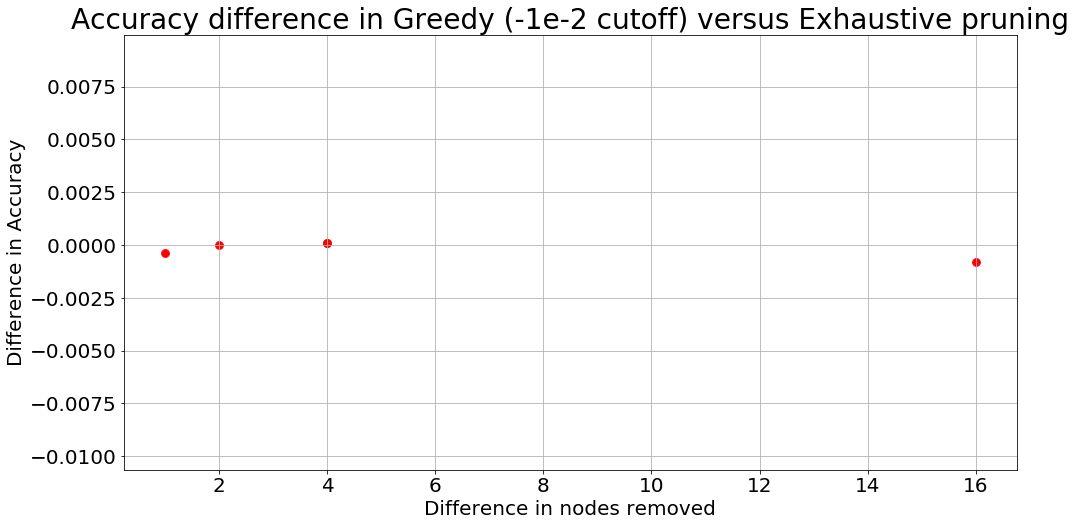

In [70]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=diff_rem, y=diff_accs, marker='o', color='red', s=60)
plt.title("Accuracy difference in Greedy (-1e-2 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_accuracy_vs_nodes_removed_CNN_greed_ex_mnist.png")

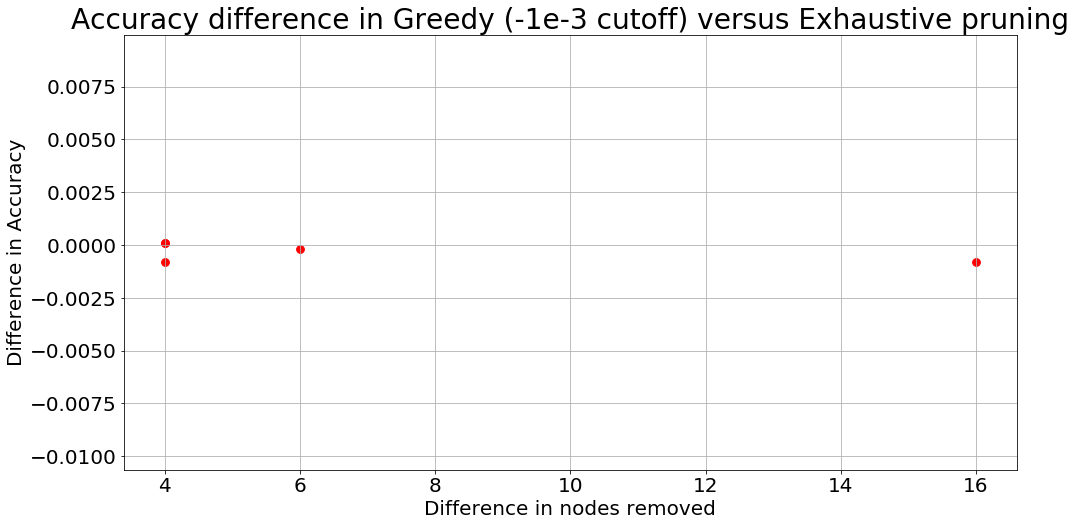

In [71]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=diff_rem2, y=diff_accs2, marker='o', color='red', s=60)
plt.title("Accuracy difference in Greedy (-1e-3 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_accuracy_vs_nodes_removed_CNN_greed_ex_2_mnist.png")

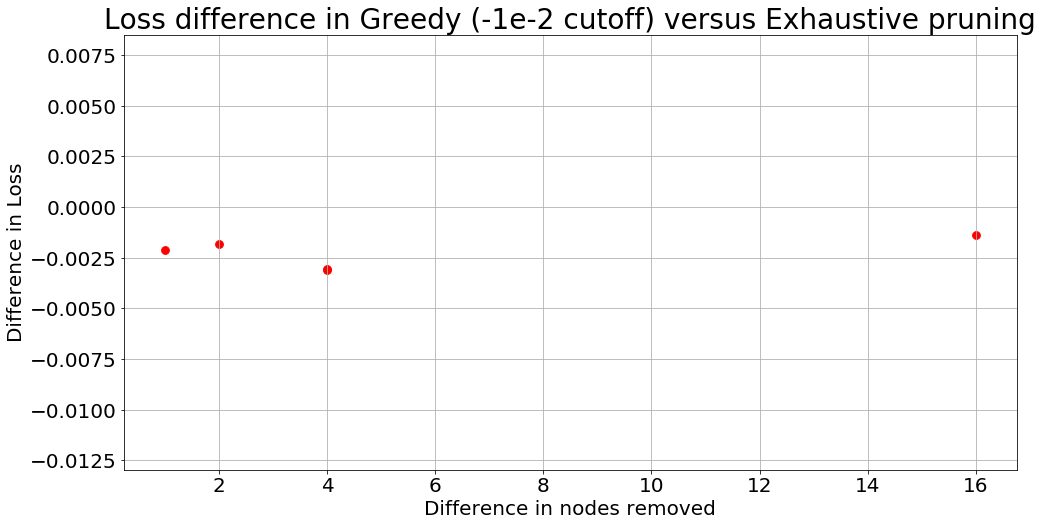

In [72]:
plt.scatter(x=diff_rem, y=diff_losses, marker='o', color='red', s=60)
plt.title("Loss difference in Greedy (-1e-2 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_loss_vs_nodes_removed_CNN_greed_ex_mnist.png")

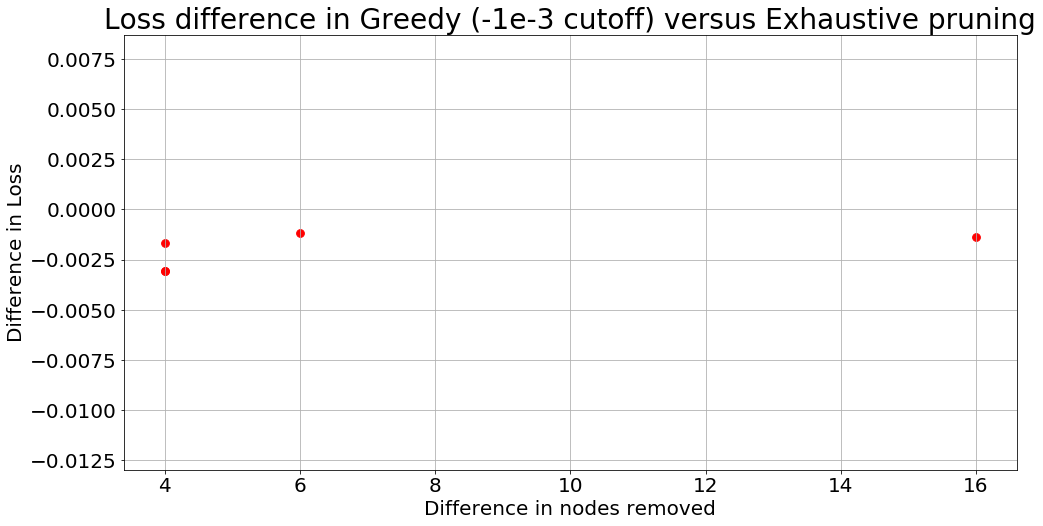

In [73]:
plt.scatter(x=diff_rem2, y=diff_losses2, marker='o', color='red', s=60)
plt.title("Loss difference in Greedy (-1e-3 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_loss_vs_nodes_removed_CNN_greed_ex_2_mnist.png")

In [74]:
tol = -1e-5
ig_cut = -1e-3
layer_sizes = [64, 256, 128, 64, 32]
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [75]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.0349515825510025, New loss: 0.03171423822641373
Original accuracy: 0.9878000020980835, New accuracy: 0.9926000237464905
Number of nodes removed: [33, 68, 18, 5, 4]


In [76]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

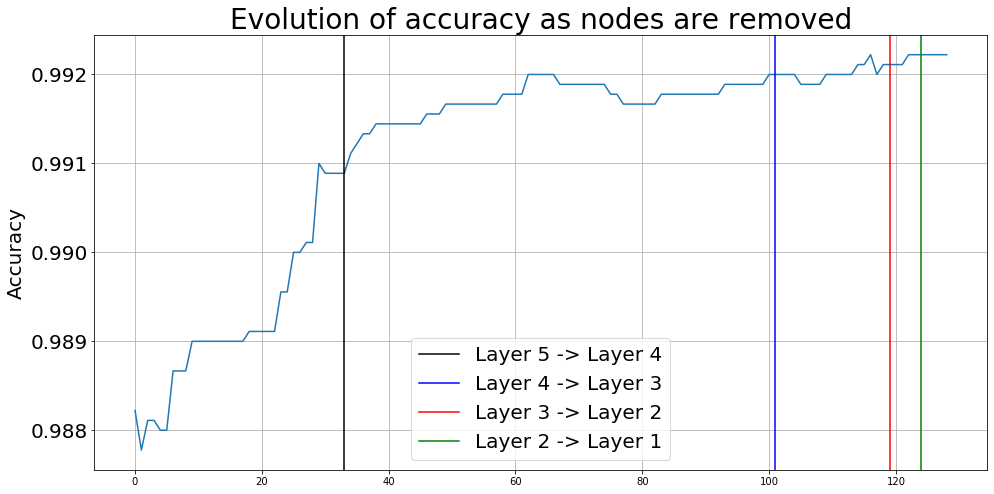

In [77]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_CNN_greed_pru_mnist.png")

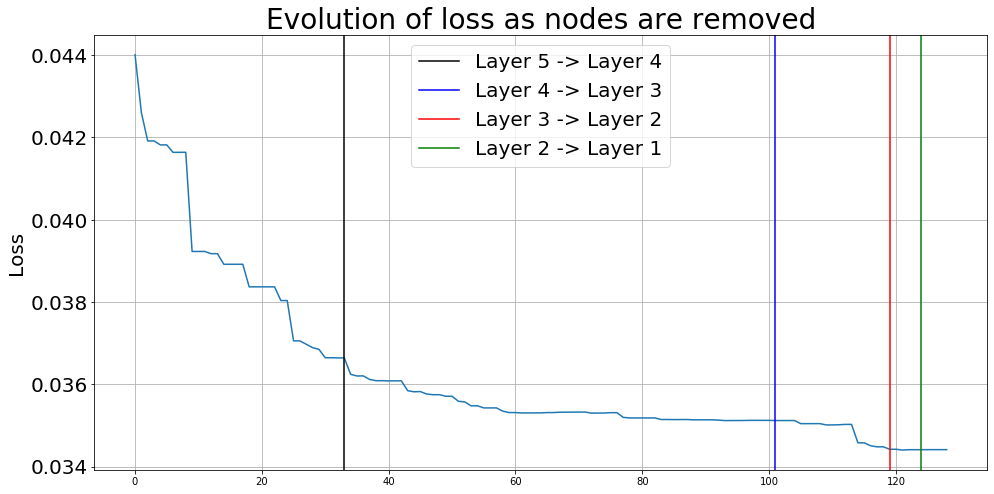

In [78]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_CNN_greed_pru_mnist.png")

### Fashion MNIST

In [79]:
np.random.seed(2020)

In [80]:
fmnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fmnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

In [81]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [82]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [83]:
trials = 5
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
num_rem_ex = []
num_rem_greed = []
num_rem_greed2 = []
delta_accs_ex = []
delta_losses_ex = []
delta_accs_greed = []
delta_losses_greed = []
delta_accs_greed2 = []
delta_losses_greed2 = []
diff_accs = []
diff_losses = []
diff_rem = []
diff_rem2 = []
diff_accs2 = []
diff_losses2 = []
time_ex = []
time_greed = []
time_greed2 = []

for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    
    ig_cut = None
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut)
    end = time.time()
    num_rem_ex += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_ex += [na - a]
    delta_losses_ex += [nl - l]
    time_ex += [end - start]
    
    ig_cut = -1e-2
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
    end = time.time()
    num_rem_greed += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_greed += [na - a]
    delta_losses_greed += [nl - l]
    time_greed += [end - start]
    
    ig_cut = -1e-3
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
    end = time.time()
    num_rem_greed2 += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_greed2 += [na - a]
    delta_losses_greed2 += [nl - l]
    time_greed2 += [end - start]
    
    diff_accs += [delta_accs_ex[trial] - delta_accs_greed[trial]]
    diff_accs2 += [delta_accs_ex[trial] - delta_accs_greed2[trial]]
    diff_losses += [delta_losses_ex[trial] - delta_losses_greed[trial]]
    diff_losses2 += [delta_losses_ex[trial] - delta_losses_greed2[trial]]
    temp_rem = []
    temp_rem2 = []
    for i in range(len(layer_sizes)):   
        temp_rem += [num_rem_greed[trial][i] - num_rem_ex[trial][i]]
        temp_rem2 += [num_rem_greed2[trial][i] - num_rem_ex[trial][i]]
        
    diff_rem += [temp_rem]
    diff_rem2 += [temp_rem2]

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [5:43:12<00:00, 4118.53s/it]


In [84]:
DR = pd.DataFrame(diff_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
DR.to_csv('../../../results/num_removed_CNN_greed_ex_fmnist.csv')
DR.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,5.00000,5.000000,5.000000,5.000000,5.000000
mean,2.00000,5.200000,1.200000,-0.600000,-0.400000
std,2.54951,7.259477,4.147288,1.516575,0.547723
min,0.00000,-2.000000,-5.000000,-3.000000,-1.000000
25%,0.00000,0.000000,-1.000000,-1.000000,-1.000000
50%,1.00000,2.000000,3.000000,0.000000,0.000000
75%,3.00000,13.000000,4.000000,0.000000,0.000000
max,6.00000,13.000000,5.000000,1.000000,0.000000


In [85]:
DR2 = pd.DataFrame(diff_rem2, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
DR2.to_csv('../../../results/num_removed_CNN_greed_ex_2_fmnist.csv')
DR2.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,5.000000,5.000000,5.00000,5.00000,5.000000
mean,1.600000,7.400000,1.00000,-0.20000,0.000000
std,1.140175,6.655825,2.12132,2.04939,0.707107
min,0.000000,-1.000000,-1.00000,-2.00000,-1.000000
25%,1.000000,2.000000,-1.00000,-2.00000,0.000000
50%,2.000000,9.000000,1.00000,0.00000,0.000000
75%,2.000000,13.000000,2.00000,0.00000,0.000000
max,3.000000,14.000000,4.00000,3.00000,1.000000


In [86]:
A = pd.DataFrame([delta_accs_ex, delta_accs_greed, delta_accs_greed2])
A = A.T
A.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
A.to_csv('../../../results/change_accuracy_CNN_greed_ex_fmnist.csv')
A.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,5.000000,5.000000,5.000000
mean,0.006800,0.005640,0.006200
std,0.005006,0.004137,0.003652
min,0.000900,0.002600,0.002600
25%,0.004400,0.002600,0.003800
50%,0.004800,0.003700,0.005600
75%,0.010800,0.007000,0.007000
max,0.013100,0.012300,0.012000


In [87]:
L = pd.DataFrame([delta_losses_ex, delta_losses_greed, delta_losses_greed2])
L = L.T
L.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
L.to_csv('../../../results/change_loss_CNN_greed_ex_fmnist.csv')
L.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,5.000000,5.000000,5.000000
mean,-0.026455,-0.020521,-0.021252
std,0.014132,0.009826,0.010176
min,-0.047423,-0.034573,-0.034392
25%,-0.033830,-0.026740,-0.029747
50%,-0.021781,-0.016377,-0.016377
75%,-0.015820,-0.013647,-0.014476
max,-0.013421,-0.011267,-0.011267


In [88]:
DA = pd.Series(diff_accs)
DA.to_csv('../../../results/diff_accuracy_CNN_greed_ex_fmnist.csv')
DA.describe()

count    5.000000
mean     0.001160
std      0.001981
min     -0.001700
25%      0.000800
50%      0.001100
75%      0.001800
max      0.003800
dtype: float64

In [89]:
DA2 = pd.Series(diff_accs2)
DA2.to_csv('../../../results/diff_accuracy_CNN_greed_ex_2_fmnist.csv')
DA2.describe()

count    5.000000
mean     0.000600
std      0.002106
min     -0.001700
25%     -0.000800
50%      0.000600
75%      0.001100
max      0.003800
dtype: float64

In [90]:
DL = pd.Series(diff_losses)
DL.to_csv('../../../results/diff_loss_CNN_greed_ex_fmnist.csv')
DL.describe()

count    5.000000
mean    -0.005934
std      0.004412
min     -0.012849
25%     -0.007090
50%     -0.005403
75%     -0.002173
max     -0.002154
dtype: float64

In [91]:
DL2 = pd.Series(diff_losses2)
DL2.to_csv('../../../results/diff_loss_CNN_greed_ex_2_fmnist.csv')
DL2.describe()

count    5.000000
mean    -0.005203
std      0.004657
min     -0.013031
25%     -0.005403
50%     -0.004083
75%     -0.002154
max     -0.001344
dtype: float64

In [92]:
Time = pd.DataFrame([time_ex, time_greed, time_greed2])
Time = Time.T
Time.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
Time.to_csv('../../../results/time_CNN_greed_ex_fmnist.csv')
Time.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,5.000000,5.000000,5.000000
mean,2395.551725,933.532901,774.594301
std,271.357802,64.818977,40.880674
min,1963.569520,847.929502,736.487999
25%,2385.102020,900.605500,743.520500
50%,2412.229522,935.463002,759.169001
75%,2516.475064,963.617499,801.892501
max,2700.382501,1020.048999,831.901501


In [93]:
diff_rem = [sum(rem) for rem in diff_rem]

In [94]:
diff_rem2 = [sum(rem) for rem in diff_rem2]

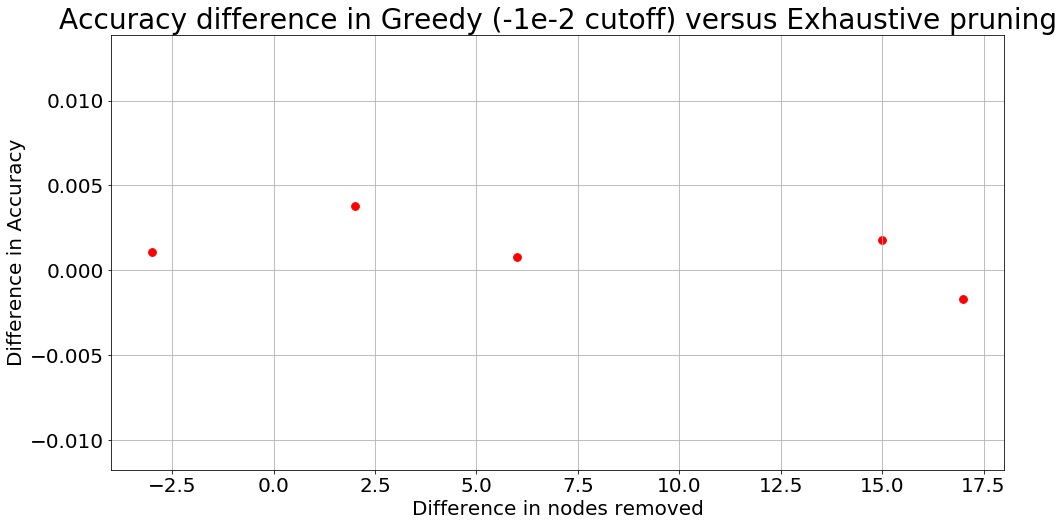

In [95]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=diff_rem, y=diff_accs, marker='o', color='red', s=60)
plt.title("Accuracy difference in Greedy (-1e-2 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_accuracy_vs_nodes_removed_CNN_greed_ex_fmnist.png")

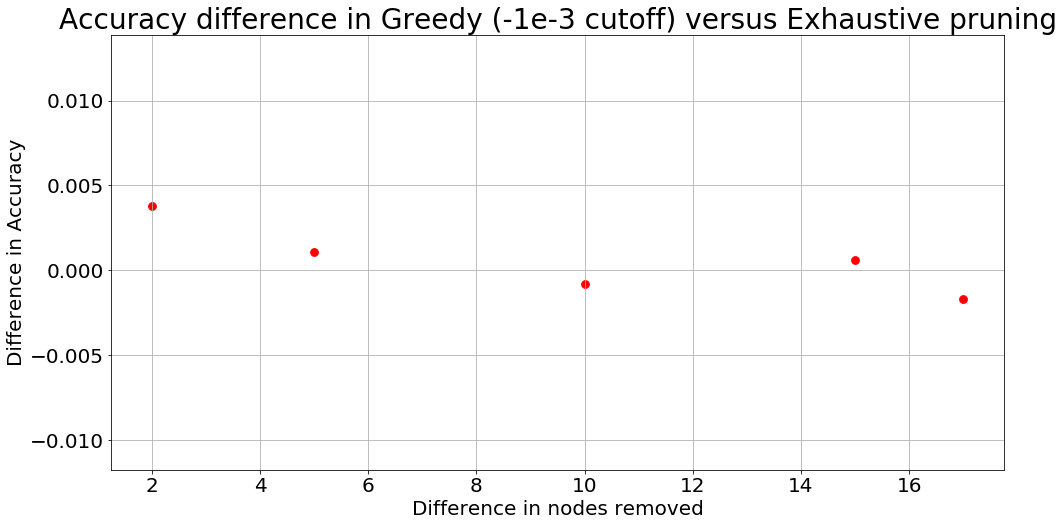

In [96]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=diff_rem2, y=diff_accs2, marker='o', color='red', s=60)
plt.title("Accuracy difference in Greedy (-1e-3 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_accuracy_vs_nodes_removed_CNN_greed_ex_2_fmnist.png")

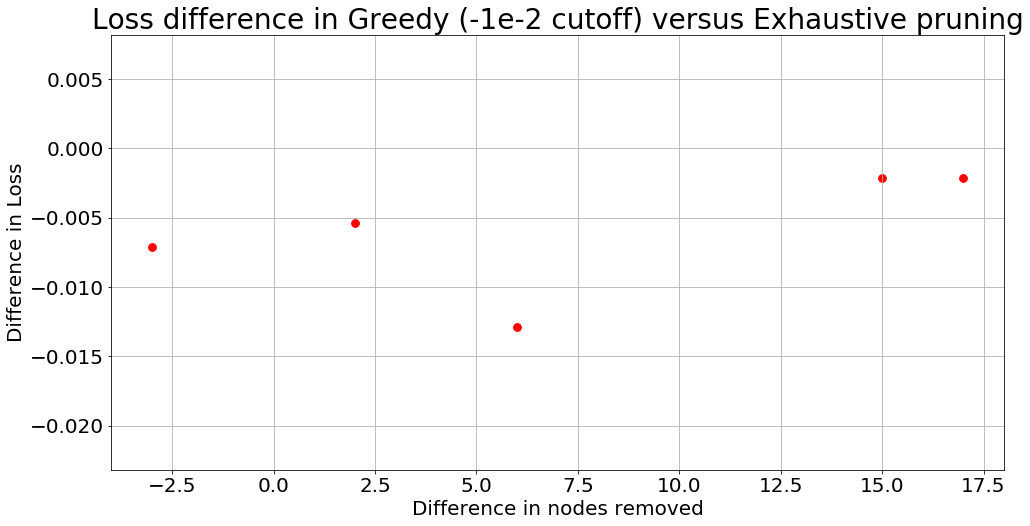

In [97]:
plt.scatter(x=diff_rem, y=diff_losses, marker='o', color='red', s=60)
plt.title("Loss difference in Greedy (-1e-2 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_loss_vs_nodes_removed_CNN_greed_ex_fmnist.png")

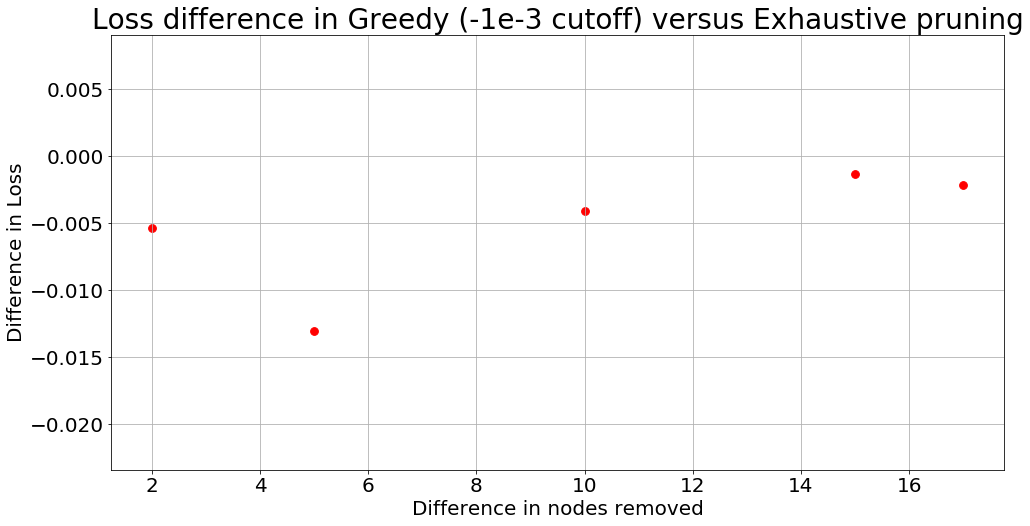

In [98]:
plt.scatter(x=diff_rem2, y=diff_losses2, marker='o', color='red', s=60)
plt.title("Loss difference in Greedy (-1e-3 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_loss_vs_nodes_removed_CNN_greed_ex_2_fmnist.png")

In [99]:
tol = -1e-5
ig_cut = -1e-3
layer_sizes = [64, 256, 128, 64, 32]
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [100]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.2405356615781784, New loss: 0.23410312831401825
Original accuracy: 0.9157999753952026, New accuracy: 0.9150999784469604
Number of nodes removed: [36, 75, 27, 3, 4]


In [101]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

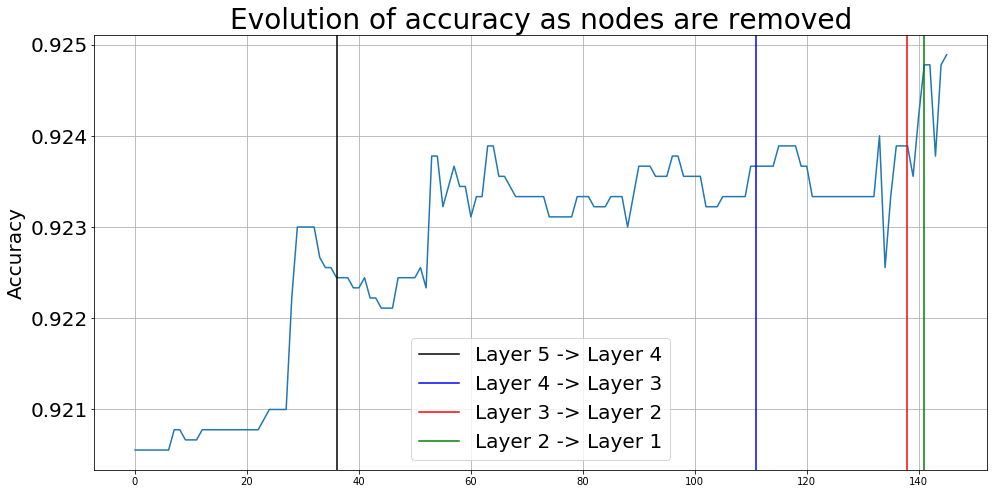

In [102]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_CNN_greed_pru_fmnist.png")

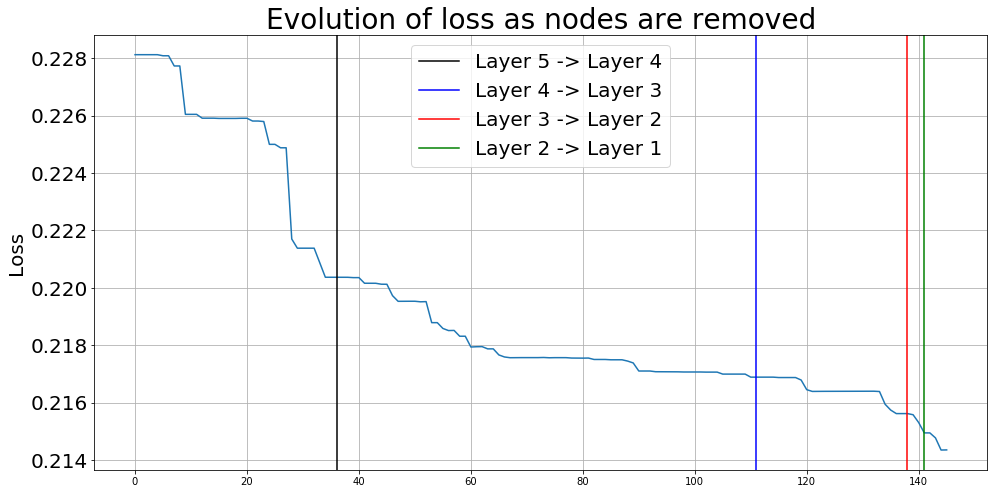

In [103]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_CNN_greed_pru_fmnist.png")

### CIFAR10

In [104]:
np.random.seed(2020)

In [105]:
cifar = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)

In [106]:
tester_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [107]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.85, stratify=None)

In [108]:
trials = 5
tol = -1e-5
layer_sizes = [64, 256, 128, 64, 32]
num_rem_ex = []
num_rem_greed = []
num_rem_greed2 = []
delta_accs_ex = []
delta_losses_ex = []
delta_accs_greed = []
delta_losses_greed = []
delta_accs_greed2 = []
delta_losses_greed2 = []
diff_accs = []
diff_losses = []
diff_rem = []
diff_rem2 = []
diff_accs2 = []
diff_losses2 = []
time_ex = []
time_greed = []
time_greed2 = []

for trial in tqdm.trange(trials):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.fit(x_train, y_train, epochs=5, verbose=0)
    l, a = model.evaluate(x_test, y_test, verbose=0)
    
    ig_cut = None
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut)
    end = time.time()
    num_rem_ex += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_ex += [na - a]
    delta_losses_ex += [nl - l]
    time_ex += [end - start]
    
    ig_cut = -1e-2
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
    end = time.time()
    num_rem_greed += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_greed += [na - a]
    delta_losses_greed += [nl - l]
    time_greed += [end - start]
    
    ig_cut = -1e-3
    
    start = time.time()
    shrinked_weights, _, _, tmp_a, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
    end = time.time()
    num_rem_greed2 += [tmp_a]
    tester_model.set_weights(shrinked_weights)
    nl, na = tester_model.evaluate(x_test, y_test, verbose=0)
    delta_accs_greed2 += [na - a]
    delta_losses_greed2 += [nl - l]
    time_greed2 += [end - start]
    
    diff_accs += [delta_accs_ex[trial] - delta_accs_greed[trial]]
    diff_accs2 += [delta_accs_ex[trial] - delta_accs_greed2[trial]]
    diff_losses += [delta_losses_ex[trial] - delta_losses_greed[trial]]
    diff_losses2 += [delta_losses_ex[trial] - delta_losses_greed2[trial]]
    temp_rem = []
    temp_rem2 = []
    for i in range(len(layer_sizes)):   
        temp_rem += [num_rem_greed[trial][i] - num_rem_ex[trial][i]]
        temp_rem2 += [num_rem_greed2[trial][i] - num_rem_ex[trial][i]]
        
    diff_rem += [temp_rem]
    diff_rem2 += [temp_rem2]

100%|███████████████████████████████████████████████████████████████████████████████| 5/5 [10:12:13<00:00, 7346.78s/it]


In [109]:
DR = pd.DataFrame(diff_rem, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
DR.to_csv('../../../results/num_removed_CNN_greed_ex_cifar.csv')
DR.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,5.0,5.00000,5.00000,5.000000,5.00000
mean,0.0,11.00000,3.20000,-0.200000,0.20000
std,0.0,5.43139,3.03315,0.447214,0.83666
min,0.0,5.00000,0.00000,-1.000000,-1.00000
25%,0.0,7.00000,2.00000,0.000000,0.00000
50%,0.0,10.00000,2.00000,0.000000,0.00000
75%,0.0,15.00000,4.00000,0.000000,1.00000
max,0.0,18.00000,8.00000,0.000000,1.00000


In [110]:
DR2 = pd.DataFrame(diff_rem2, columns=["Layer 5", "Layer 4", "Layer 3", "Layer 2", "Layer 1"])
DR2.to_csv('../../../results/num_removed_CNN_greed_ex_2_cifar.csv')
DR2.describe()

,Layer 5,Layer 4,Layer 3,Layer 2,Layer 1
count,5.0,5.00000,5.00000,5.000000,5.00000
mean,0.0,11.00000,2.40000,-0.200000,0.20000
std,0.0,5.43139,1.67332,0.447214,0.83666
min,0.0,5.00000,0.00000,-1.000000,-1.00000
25%,0.0,7.00000,2.00000,0.000000,0.00000
50%,0.0,10.00000,2.00000,0.000000,0.00000
75%,0.0,15.00000,4.00000,0.000000,1.00000
max,0.0,18.00000,4.00000,0.000000,1.00000


In [111]:
A = pd.DataFrame([delta_accs_ex, delta_accs_greed, delta_accs_greed2])
A = A.T
A.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
A.to_csv('../../../results/change_accuracy_CNN_greed_ex_cifar.csv')
A.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,5.000000,5.00000,5.000000
mean,0.003040,0.00180,0.002000
std,0.005176,0.00375,0.003843
min,-0.004100,-0.00240,-0.002400
25%,-0.000600,-0.00190,-0.001900
50%,0.005700,0.00280,0.003800
75%,0.005900,0.00500,0.005000
max,0.008300,0.00550,0.005500


In [112]:
L = pd.DataFrame([delta_losses_ex, delta_losses_greed, delta_losses_greed2])
L = L.T
L.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
L.to_csv('../../../results/change_loss_CNN_greed_ex_cifar.csv')
L.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,5.000000,5.000000,5.000000
mean,-0.038270,-0.027201,-0.027758
std,0.011550,0.010302,0.011002
min,-0.052747,-0.039648,-0.039648
25%,-0.048668,-0.036789,-0.039574
50%,-0.031692,-0.021642,-0.021642
75%,-0.030739,-0.021309,-0.021309
max,-0.027505,-0.016615,-0.016615


In [113]:
DA = pd.Series(diff_accs)
DA.to_csv('../../../results/diff_accuracy_CNN_greed_ex_cifar.csv')
DA.describe()

count    5.000000
mean     0.001240
std      0.001926
min     -0.001700
25%      0.000700
50%      0.001300
75%      0.002800
max      0.003100
dtype: float64

In [114]:
DA2 = pd.Series(diff_accs2)
DA2.to_csv('../../../results/diff_accuracy_CNN_greed_ex_2_cifar.csv')
DA2.describe()

count    5.000000
mean     0.001040
std      0.001726
min     -0.001700
25%      0.000700
50%      0.001300
75%      0.002100
max      0.002800
dtype: float64

In [115]:
DL = pd.Series(diff_losses)
DL.to_csv('../../../results/diff_loss_CNN_greed_ex_cifar.csv')
DL.describe()

count    5.000000
mean    -0.011070
std      0.002822
min     -0.015958
25%     -0.010891
50%     -0.010049
75%     -0.009430
max     -0.009020
dtype: float64

In [116]:
DL2 = pd.Series(diff_losses2)
DL2.to_csv('../../../results/diff_loss_CNN_greed_ex_2_cifar.csv')
DL2.describe()

count    5.000000
mean    -0.010513
std      0.001646
min     -0.013173
25%     -0.010891
50%     -0.010049
75%     -0.009430
max     -0.009020
dtype: float64

In [117]:
Time = pd.DataFrame([time_ex, time_greed, time_greed2])
Time = Time.T
Time.columns = ['Exhaustive', 'Greedy (-1e-2 cutoff)', 'Greedy (-1e-3 cutoff)']
Time.to_csv('../../../results/time_CNN_greed_ex_cifar.csv')
Time.describe()

,Exhaustive,Greedy (-1e-2 cutoff),Greedy (-1e-3 cutoff)
count,5.000000,5.000000,5.000000
mean,5415.365933,1443.773999,473.405625
std,1330.568567,95.434752,57.158788
min,4695.056175,1333.095499,437.306607
25%,4710.690498,1403.826999,439.179996
50%,4932.613505,1413.226000,442.629000
75%,4952.644489,1483.171998,476.332521
max,7785.825000,1585.549497,571.580001


In [118]:
diff_rem = [sum(rem) for rem in diff_rem]

In [119]:
diff_rem2 = [sum(rem) for rem in diff_rem2]

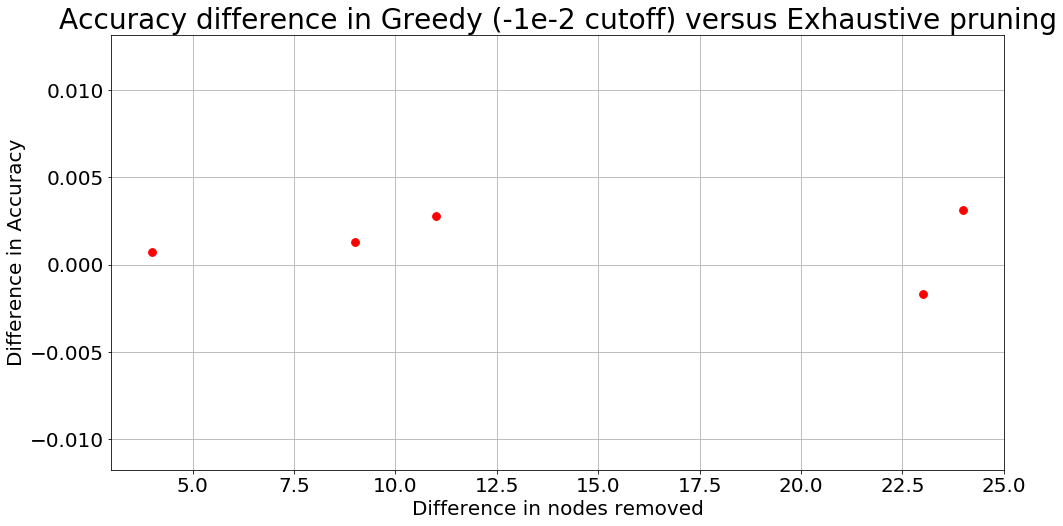

In [120]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=diff_rem, y=diff_accs, marker='o', color='red', s=60)
plt.title("Accuracy difference in Greedy (-1e-2 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_accuracy_vs_nodes_removed_CNN_greed_ex_cifar.png")

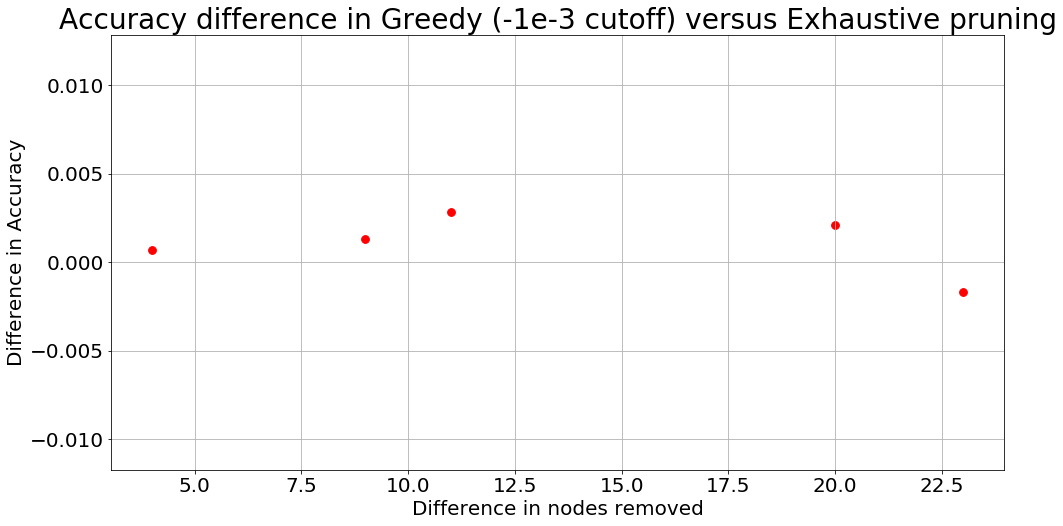

In [121]:
plt.rcParams["figure.figsize"] = (16,8)
plt.scatter(x=diff_rem2, y=diff_accs2, marker='o', color='red', s=60)
plt.title("Accuracy difference in Greedy (-1e-3 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_accuracy_vs_nodes_removed_CNN_greed_ex_2_cifar.png")

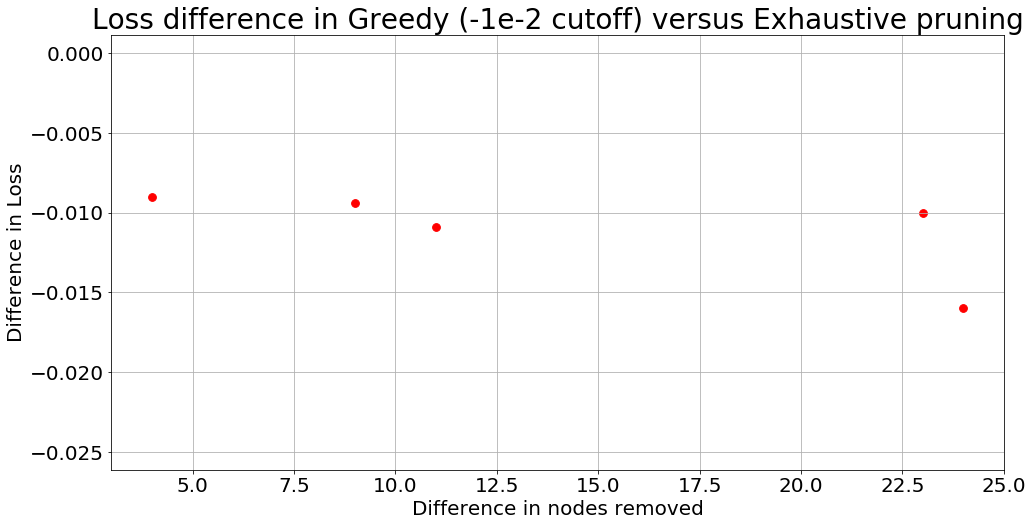

In [122]:
plt.scatter(x=diff_rem, y=diff_losses, marker='o', color='red', s=60)
plt.title("Loss difference in Greedy (-1e-2 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_loss_vs_nodes_removed_CNN_greed_ex_cifar.png")

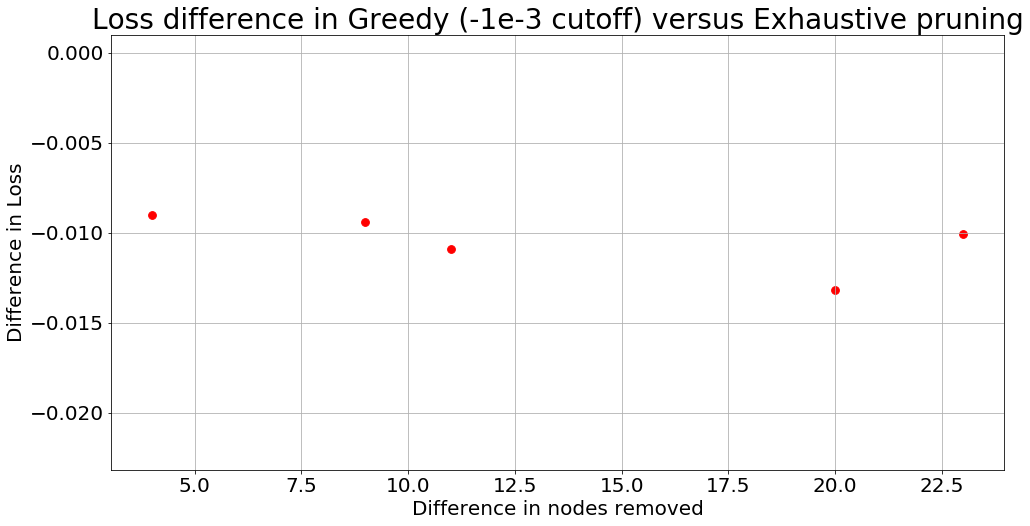

In [123]:
plt.scatter(x=diff_rem2, y=diff_losses2, marker='o', color='red', s=60)
plt.title("Loss difference in Greedy (-1e-3 cutoff) versus Exhaustive pruning", size=28)
plt.xlabel("Difference in nodes removed", size=20)
plt.xticks(fontsize=20)
plt.ylabel("Difference in Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.savefig("../../../figures/diff_loss_vs_nodes_removed_CNN_greed_ex_2_cifar.png")

In [124]:
tol = -1e-5
ig_cut = -1e-3
layer_sizes = [64, 256, 128, 64, 32]
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(x_train, y_train, epochs=5, verbose=0)
shrinked_weights, acc_ev, loss_ev, num_rem, _ = node_pruning(model, tester_model, x_val, y_val, layer_sizes, tol, ig_cut, method='greedy')
l, a = model.evaluate(x_test, y_test, verbose=0)
tester_model.set_weights(shrinked_weights)
nl, na = tester_model.evaluate(x_test, y_test, verbose=0)

In [125]:
print(f"Original loss: {l}, New loss: {nl}")
print(f"Original accuracy: {a}, New accuracy: {na}")
print(f"Number of nodes removed: {num_rem}")

Original loss: 0.7979344129562378, New loss: 0.7762603759765625
Original accuracy: 0.7343999743461609, New accuracy: 0.7343000173568726
Number of nodes removed: [47, 107, 30, 10, 6]


In [126]:
changes = []
tot_rem = 0
for rem in num_rem:
    tot_rem += rem
    changes.append(tot_rem)
colors = ["black", "blue", "red", "green"]

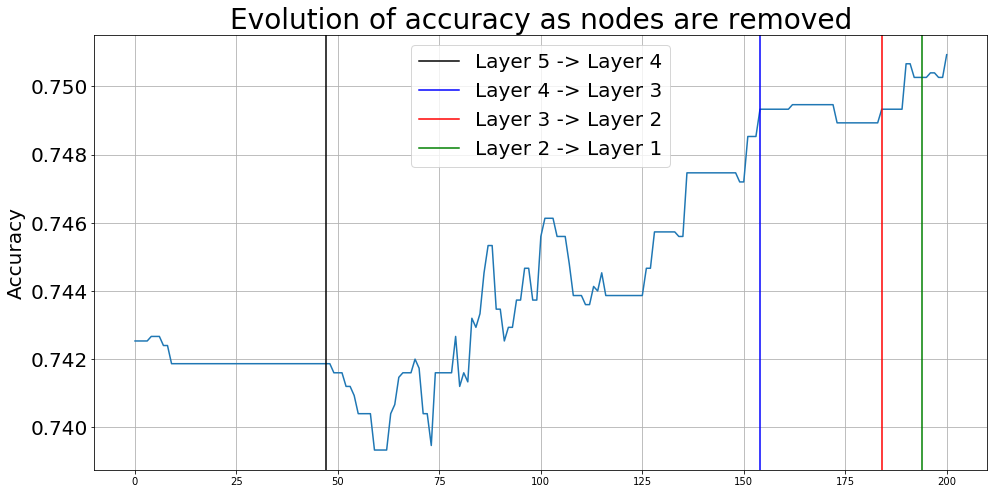

In [127]:
plt.plot(acc_ev)
plt.title("Evolution of accuracy as nodes are removed", size=28)
plt.ylabel("Accuracy", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_acc_CNN_greed_pru_cifar.png")

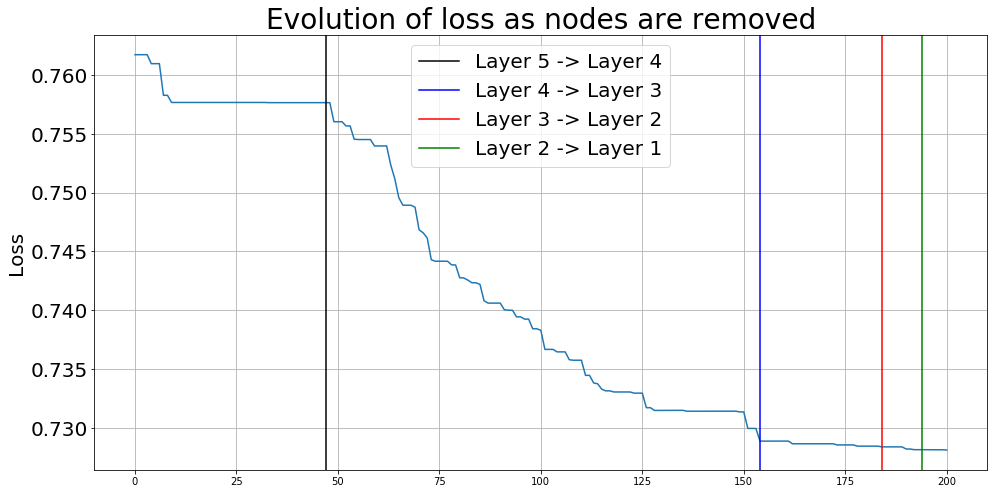

In [128]:
plt.plot(loss_ev)
plt.title("Evolution of loss as nodes are removed", size=28)
plt.ylabel("Loss", size=20)
plt.yticks(fontsize=20)
plt.grid(True)
num_layers = len(changes)
for i, pos in enumerate(changes[:-1]):
    plt.axvline(x=pos, label=f"Layer {num_layers-i} -> Layer {num_layers-(i+1)}", color=colors[i])
plt.legend(fontsize=20)
plt.savefig("../../../figures/ev_loss_CNN_greed_pru_cifar.png")